# Download Dataset

In [ ]:
!nvidia-smi -L

In [ ]:
! pip install torch torchvision
! mkdir datasets

In [ ]:
! python -c "import torch; print('torch version: ', torch.__version__)"
! python -c "import torchvision; print('torchvision version: ', torchvision.__version__)"

In [ ]:
%%bash
FILE="facades" 
URL=https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/$FILE.tar.gz 
TAR_FILE=./datasets/$FILE.tar.gz 
TARGET_DIR=./datasets/$FILE/ 
wget -N $URL -O $TAR_FILE 
mkdir $TARGET_DIR  
tar -zxvf $TAR_FILE -C ./datasets/ 
rm $TAR_FILE

In [2]:
! mkdir pix2pix
! mkdir pix2pix/model pix2pix/fig

In [3]:
model_name = "pix2pix"

# Data Handle

In [4]:
import torch
from torch.utils import data
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# load data & data argumentation
def expand_image(input_img_data):
    assert type(input_img_data)==np.ndarray
    input_img = Image.fromarray(input_img_data)
    assert type(input_img)==Image.Image
    expanded_img = input_img.resize((286, 286),Image.ANTIALIAS) 
    return expanded_img

def crop_image(expanded_img, box):
    return np.array(expanded_img.crop(box))

def concat_n_show_images(image_data_list):
    img_data = np.concatenate(image_data_list, 1)
    imgplot = plt.imshow(img_data)
    
def data_argumentation_for_single_image(real_img_data, cond_img_data,                                    c_crop=5):
    expanded_real_img, expanded_cond_img = \
    map(expand_image, [real_img_data, cond_img_data])
    real_img_data_list = [real_img_data]
    cond_img_data_list = [cond_img_data]
    for i in range(c_crop):
        offset_x, offset_y = np.random.randint(0,30,2)
        box_ = (offset_x, offset_y, offset_x+256, offset_y+256)
        crop_image_fn = lambda img: crop_image(img, box=box_)
        cropped_real_img_data, cropped_cond_img_data =  \
        map(crop_image_fn, [expanded_real_img, expanded_cond_img])
        real_img_data_list.append(cropped_real_img_data)
        cond_img_data_list.append(cropped_cond_img_data)
    return real_img_data_list, cond_img_data_list

def load_data_with_data_argumentation(mode='train', print_sample=False):
    file_path = f"./datasets/facades/{mode}/"
    n_image = len(glob.glob(file_path+"*.jpg"))
    real_img_data_list = []
    cond_img_data_list = []
    for i in range(n_image):
        img_data = np.array(Image.open(file_path+str(i+1)+".jpg")) # (256, 512, 3)
        real_img_data, cond_img_data = img_data[:,:256,:], img_data[:,256:,:] # (256, 256, 3)
        real_img_data_list_, cond_img_data_list_ =  \
        data_argumentation_for_single_image(real_img_data, cond_img_data)
        real_img_data_list += real_img_data_list_
        cond_img_data_list += cond_img_data_list_ 
    if print_sample:
        rand_idx = [0]
        #rand_idx = np.random.randint(0, len(real_img_data_list), 1)
        for i in rand_idx:
            concat_n_show_images([real_img_data_list[i], cond_img_data_list[i]])
    return np.array(real_img_data_list), np.array(cond_img_data_list)

#real_imgs, cond_imgs = load_data_with_data_argumentation('test', print_sample=True)
#real_imgs.shape # (636, 256, 256, 3)

In [6]:
class myDataset(data.Dataset):
    def __init__(self, mode='train', pad_width=0):
        super(myDataset, self).__init__()
        self.real_imgs, self.cond_imgs = map(torch.from_numpy, load_data_with_data_argumentation(mode=mode))
        self.permute_fn =  lambda t : t.permute(0,3,1,2).float() # reshape
        self.scale_fn = lambda t : torch.clamp(t/127.5-1, min=-1, max=1)
        self.real_imgs, self.cond_imgs = map(self.permute_fn, [self.real_imgs, self.cond_imgs])
        self.real_imgs, self.cond_imgs = map(self.scale_fn, [self.real_imgs, self.cond_imgs])

    def __getitem__(self, index):
        real_img, cond_img = self.real_imgs[index], self.cond_imgs[index]
        return real_img, cond_img
        
    def __len__(self):
        return self.real_imgs.shape[0]
      
    
#d = myDataset() 
#d.__len__()

In [7]:
train_loader = data.DataLoader(myDataset('train'), batch_size=10, shuffle=True)
test_loader = data.DataLoader(myDataset('test'), batch_size=10, shuffle=True)
val_loader = data.DataLoader(myDataset('val'), batch_size=10, shuffle=True)

# Model

In [8]:
import torch
from torch import nn
  
class UnetGenerator(nn.Module):
    def __init__(self):
        super(UnetGenerator, self).__init__()
        # enc
        self.enc1 = nn.Conv2d(  3,  64, 4, stride=2, padding=2)
        self.enc2 = nn.Conv2d( 64, 128, 4, stride=2, padding=2)
        self.enc3 = nn.Conv2d(128, 256, 4, stride=2, padding=2)
        self.enc4 = nn.Conv2d(256, 512, 4, stride=2, padding=2)        
        self.enc5 = nn.Conv2d(512, 512, 4, stride=2, padding=2) 
        self.enc6 = nn.Conv2d(512, 512, 4, stride=2, padding=2) 
        self.enc7 = nn.Conv2d(512, 512, 4, stride=2, padding=2) 
        self.enc8 = nn.Conv2d(512, 512, 2, stride=2, padding=1) 
        self.enc_bn2 = nn.BatchNorm2d(128)
        self.enc_bn3 = nn.BatchNorm2d(256)
        self.enc_bn4 = nn.BatchNorm2d(512)        
        self.enc_bn5 = nn.BatchNorm2d(512) 
        self.enc_bn6 = nn.BatchNorm2d(512) 
        self.enc_bn7 = nn.BatchNorm2d(512) 
        self.enc_bn8 = nn.BatchNorm2d(512) 
        # dec
        self.dec1 = nn.ConvTranspose2d(  512, 512, 2, stride=1,  ) 
        self.dec2 = nn.ConvTranspose2d(512*2, 512, 2, stride=2, padding=1, output_padding=1) 
        self.dec3 = nn.ConvTranspose2d(512*2, 512, 4, stride=2, padding=2, output_padding=1) 
        self.dec4 = nn.ConvTranspose2d(512*2, 512, 4, stride=2, padding=2, output_padding=1)         
        self.dec5 = nn.ConvTranspose2d(512*2, 256, 4, stride=2, padding=2, output_padding=1)  
        self.dec6 = nn.ConvTranspose2d(256*2, 128, 4, stride=2, padding=2, output_padding=1)  
        self.dec7 = nn.ConvTranspose2d(128*2,  64, 4, stride=2, padding=2, output_padding=1)  
        self.dec8 = nn.ConvTranspose2d( 64*2,   3, 4, stride=2, padding=2,)  
        self.dec_bn1 = nn.BatchNorm2d(512)
        self.dec_bn2 = nn.BatchNorm2d(512)
        self.dec_bn3 = nn.BatchNorm2d(512)        
        self.dec_bn4 = nn.BatchNorm2d(512) 
        self.dec_bn5 = nn.BatchNorm2d(256) 
        self.dec_bn6 = nn.BatchNorm2d(128) 
        self.dec_bn7 = nn.BatchNorm2d(64) 
        # act
        self.enc_act = nn.LeakyReLU(0.2)
        self.dec_act = nn.ReLU()
        
        
    def forward(self, x):
        # enc
        e1 = self.enc1(x)                               #;print('e1:', e1.shape)
        e2 = self.enc_bn2(self.enc_act(self.enc2(e1)))  #;print('e2:', e2.shape)
        e3 = self.enc_bn3(self.enc_act(self.enc3(e2)))  #;print('e3:', e3.shape)
        e4 = self.enc_bn4(self.enc_act(self.enc4(e3)))  #;print('e4:', e4.shape)
        e5 = self.enc_bn5(self.enc_act(self.enc5(e4)))  #;print('e5:', e5.shape)
        e6 = self.enc_bn6(self.enc_act(self.enc6(e5)))  #;print('e6:', e6.shape)
        e7 = self.enc_bn7(self.enc_act(self.enc7(e6)))  #;print('e7:', e7.shape)
        e8 = self.enc_bn8(self.enc_act(self.enc8(e7)))  #;print('e8:', e8.shape)
        # dec
        d1 = self.dec_bn1(self.dec_act(self.dec1(e8)))  #;print('d1:', d1.shape)
        d1c = torch.cat([d1, e7], 1)                    #;print('d1c:', d1c.shape)
        d2 = self.dec_bn2(self.dec_act(self.dec2(d1c))) #;print('d2:', d2.shape)
        d2c = torch.cat([d2, e6], 1)                    #;print('d2c:', d2c.shape)
        d3 = self.dec_bn3(self.dec_act(self.dec3(d2c))) #;print('d3:', d3.shape)
        d3c = torch.cat([d3, e5], 1)                    #;print('d3c:', d3c.shape)
        d4 = self.dec_bn4(self.dec_act(self.dec4(d3c))) #;print('d4:', d4.shape)
        d4c = torch.cat([d4, e4], 1)                    #;print('d4c:', d4c.shape)
        d5 = self.dec_bn5(self.dec_act(self.dec5(d4c))) #;print('d5:', d5.shape)
        d5c = torch.cat([d5, e3], 1)                    #;print('d5c:', d5c.shape)
        d6 = self.dec_bn6(self.dec_act(self.dec6(d5c))) #;print('d6:', d6.shape)
        d6c = torch.cat([d6, e2], 1)                    #;print('d6c:', d6c.shape)
        d7 = self.dec_bn7(self.dec_act(self.dec7(d6c))) #;print('d7:', d7.shape)
        d7c = torch.cat([d7, e1], 1)                    #;print('d7c:', d7c.shape)
        d8 = nn.Tanh()(self.dec8(d7c))                  #;print('d8:', d8.shape)        
        
        return d8
    
#G = UnetGenerator().cuda()
#gen_img = G(cond_img)
#gen_img.shape # torch.Size([1, 3, 256, 256])

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3*2,  64, 4, stride=2, padding=2)
        self.conv2 = nn.Conv2d( 64, 128, 4, stride=2, padding=2)
        self.conv3 = nn.Conv2d(128, 256, 4, stride=2, padding=2)
        self.conv4 = nn.Conv2d(256, 512, 4, stride=2, padding=2)        
        self.conv_bn1 = nn.BatchNorm2d(64)
        self.conv_bn2 = nn.BatchNorm2d(128)
        self.conv_bn3 = nn.BatchNorm2d(256)        
        self.conv_bn4 = nn.BatchNorm2d(512) 
        self.fc = nn.Linear(512*17*17, 1)
        self.conv_act = nn.LeakyReLU(0.2)
        self.op_act = nn.Sigmoid()
        
    def forward(self, x):
        # enc
        x = self.conv_bn1(self.conv_act(self.conv1(x)))  #;print('L1:', x.shape)
        x = self.conv_bn2(self.conv_act(self.conv2(x)))  #;print('L2:', x.shape)  
        x = self.conv_bn3(self.conv_act(self.conv3(x)))  #;print('L3:', x.shape)
        x = self.conv_bn4(self.conv_act(self.conv4(x)))  #;print('L4:', x.shape)
        x = self.fc(x.view(x.shape[0], -1))              #;print('out:', x.shape)
        return self.op_act(x)
    
#D = Discriminator().cuda()
#y = D(torch.cat([gen_img, cond_img],1))
#y.shape

In [10]:
def forward_n_get_loss(real_img, cond_img, G, D, c=100):
    fake_img = G(cond_img) 
    real_pair = torch.cat([real_img, cond_img], 1)
    fake_pair = torch.cat([fake_img, cond_img], 1)
    prob_real, prob_fake = D(real_pair), D(fake_pair.detach())
    # loss_D
    loss_D_real = nn.BCELoss()(prob_real, torch.ones_like(prob_real))
    loss_D_fake = nn.BCELoss()(prob_fake, torch.zeros_like(prob_fake))
    loss_D = (loss_D_real + loss_D_fake) *0.5
    # loss_G
    loss_G_fake = nn.BCELoss()(prob_fake, torch.ones_like(prob_fake))
    loss_G_L1 = nn.L1Loss()(fake_img, real_img)
    loss_G = loss_G_fake + c*loss_G_L1
    return loss_D, loss_G, loss_D_real, loss_D_fake, loss_G_fake, loss_G_L1


In [11]:
# build model 
use_cuda = torch.cuda.is_available()
print('use_cuda:', use_cuda)
if use_cuda:
    G = UnetGenerator().cuda()
    D = Discriminator().cuda()
else:
    G = UnetGenerator()
    D = Discriminator()  

use_cuda: True


In [12]:
# initialize weights
def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
        m.weight.data.normal_(0, 0.02)
        m.bias.data.normal_(0, 0.02)
G.apply(init_weights)
D.apply(init_weights)
print(G.enc1.weight.data.mean().mean())# close to 0.00
print(G.enc1.weight.data.std().mean())# close to 0.02

tensor(0.0003, device='cuda:0')
tensor(0.0204, device='cuda:0')


# Train

In [13]:
from torch.optim import Adam
optimizer_G = Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))

In [14]:
rescale_fn = lambda t : torch.clamp(((t+1)*0.5*256).long(), min=0, max=255)
def show_img(fake_img):
    #print(fake_img.shape)
    data = rescale_fn(fake_img).cpu().detach().numpy().transpose((1, 2, 0))
    #print(data.shape)
    plt.axis('off')
    imgplot = plt.imshow(data)

def sample_img(G, data_loader, PATH="test.jpg"):
    G.eval()
    real_img_batch, cond_img_batch = next(iter(data_loader))
    if use_cuda: real_img_batch, cond_img_batch = real_img_batch.cuda(), cond_img_batch.cuda() 
    fake_img_batch = G(cond_img_batch)
    img_batch = torch.cat((real_img_batch, cond_img_batch, fake_img_batch), 3)
    #print(img_batch.shape)
    show_img(img_batch[0]) #印第一張出來看
    plt.savefig(PATH)
    plt.show()
    G.train()

torch.Size([10, 3, 256, 768])


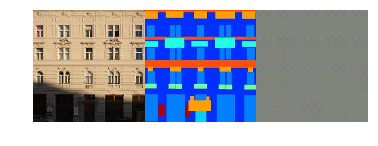

In [15]:
# test
#G.load_state_dict(torch.load("model/G_0269"))
sample_img(G, train_loader)

[0] {'loss_D': 0.0002, 'loss_G': 46.3791, 'loss_D_real': 0.0003, 'loss_D_fake': 0.0, 'loss_G_fake': 15.826, 'loss_G_L1': 0.3055}, time_cost: 0.75 min
torch.Size([10, 3, 256, 768])


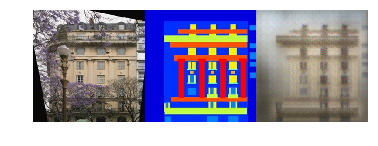

[9] {'loss_D': 0.0, 'loss_G': 55.1034, 'loss_D_real': 0.0, 'loss_D_fake': 0.0, 'loss_G_fake': 37.7476, 'loss_G_L1': 0.1736}, time_cost: 6.97 min
torch.Size([10, 3, 256, 768])


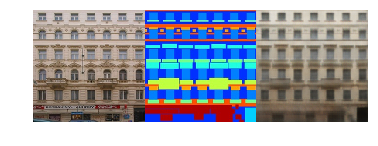

[19] {'loss_D': 0.0, 'loss_G': 40.9386, 'loss_D_real': 0.0, 'loss_D_fake': 0.0, 'loss_G_fake': 27.757, 'loss_G_L1': 0.1318}, time_cost: 7.75 min
torch.Size([10, 3, 256, 768])


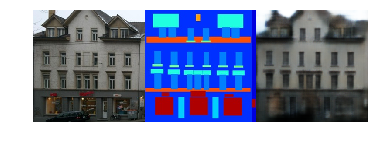

[29] {'loss_D': 0.0, 'loss_G': 58.1029, 'loss_D_real': 0.0, 'loss_D_fake': 0.0, 'loss_G_fake': 44.9718, 'loss_G_L1': 0.1313}, time_cost: 7.73 min
torch.Size([10, 3, 256, 768])


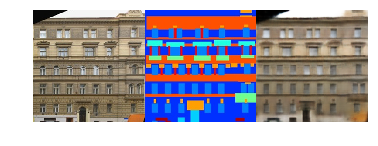

[39] {'loss_D': 4.1447, 'loss_G': 44.5773, 'loss_D_real': 0.0, 'loss_D_fake': 8.2893, 'loss_G_fake': 34.1456, 'loss_G_L1': 0.1043}, time_cost: 7.72 min
torch.Size([10, 3, 256, 768])


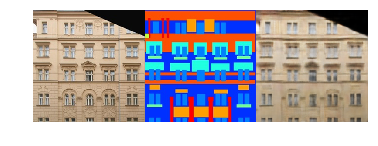

[49] {'loss_D': 0.0, 'loss_G': 37.5249, 'loss_D_real': 0.0, 'loss_D_fake': 0.0, 'loss_G_fake': 27.631, 'loss_G_L1': 0.0989}, time_cost: 7.72 min
torch.Size([10, 3, 256, 768])


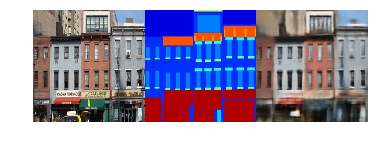

[59] {'loss_D': 0.0, 'loss_G': 37.3568, 'loss_D_real': 0.0, 'loss_D_fake': 0.0, 'loss_G_fake': 27.631, 'loss_G_L1': 0.0973}, time_cost: 7.72 min
torch.Size([10, 3, 256, 768])


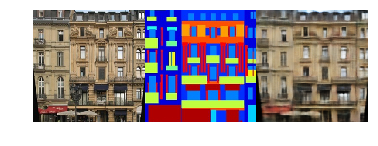

[69] {'loss_D': 0.0, 'loss_G': 36.9419, 'loss_D_real': 0.0, 'loss_D_fake': 0.0, 'loss_G_fake': 27.631, 'loss_G_L1': 0.0931}, time_cost: 7.72 min
torch.Size([10, 3, 256, 768])


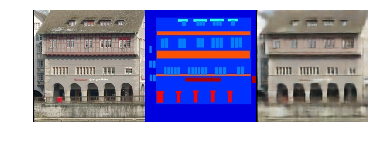

[79] {'loss_D': 0.0, 'loss_G': 35.8137, 'loss_D_real': 0.0, 'loss_D_fake': 0.0, 'loss_G_fake': 27.631, 'loss_G_L1': 0.0818}, time_cost: 7.72 min
torch.Size([10, 3, 256, 768])


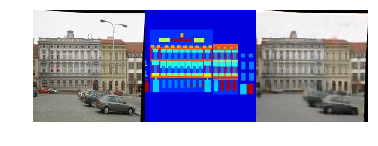

[89] {'loss_D': 0.0, 'loss_G': 35.8925, 'loss_D_real': 0.0, 'loss_D_fake': 0.0, 'loss_G_fake': 27.631, 'loss_G_L1': 0.0826}, time_cost: 7.71 min
torch.Size([10, 3, 256, 768])


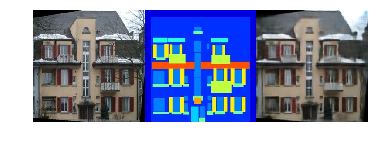

[99] {'loss_D': 0.0, 'loss_G': 37.0916, 'loss_D_real': 0.0, 'loss_D_fake': 0.0, 'loss_G_fake': 27.631, 'loss_G_L1': 0.0946}, time_cost: 7.71 min
torch.Size([10, 3, 256, 768])


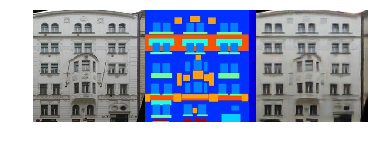

[109] {'loss_D': 0.0, 'loss_G': 35.0194, 'loss_D_real': 0.0, 'loss_D_fake': 0.0, 'loss_G_fake': 27.631, 'loss_G_L1': 0.0739}, time_cost: 7.72 min
torch.Size([10, 3, 256, 768])


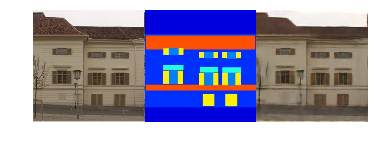

[119] {'loss_D': 0.0, 'loss_G': 47.4344, 'loss_D_real': 0.0, 'loss_D_fake': 0.0, 'loss_G_fake': 39.6342, 'loss_G_L1': 0.078}, time_cost: 7.12 min
torch.Size([10, 3, 256, 768])


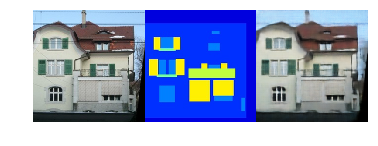

[129] {'loss_D': 0.0, 'loss_G': 35.6413, 'loss_D_real': 0.0, 'loss_D_fake': 0.0, 'loss_G_fake': 27.631, 'loss_G_L1': 0.0801}, time_cost: 7.09 min
torch.Size([10, 3, 256, 768])


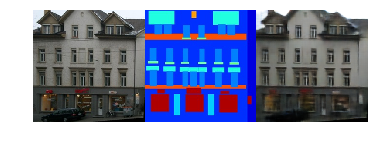

[139] {'loss_D': 0.0, 'loss_G': 34.5662, 'loss_D_real': 0.0, 'loss_D_fake': 0.0, 'loss_G_fake': 27.631, 'loss_G_L1': 0.0694}, time_cost: 7.09 min
torch.Size([10, 3, 256, 768])


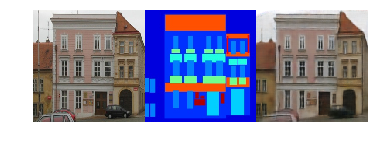

[149] {'loss_D': 0.0, 'loss_G': 35.5163, 'loss_D_real': 0.0, 'loss_D_fake': 0.0, 'loss_G_fake': 27.631, 'loss_G_L1': 0.0789}, time_cost: 7.09 min
torch.Size([10, 3, 256, 768])


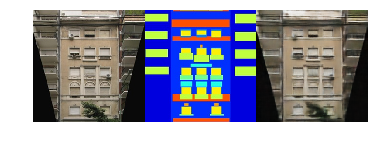

[159] {'loss_D': 0.0, 'loss_G': 34.9589, 'loss_D_real': 0.0, 'loss_D_fake': 0.0, 'loss_G_fake': 27.631, 'loss_G_L1': 0.0733}, time_cost: 7.09 min
torch.Size([10, 3, 256, 768])


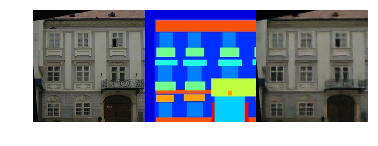

[169] {'loss_D': 0.0, 'loss_G': 39.1409, 'loss_D_real': 0.0, 'loss_D_fake': 0.0, 'loss_G_fake': 31.9551, 'loss_G_L1': 0.0719}, time_cost: 7.09 min
torch.Size([10, 3, 256, 768])


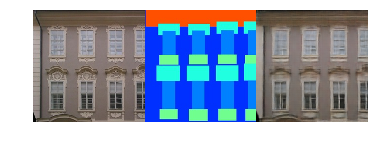

In [ ]:
# train!
import time
start_epo = 0
n_epochs = 200
print_freq = 10
st = time.time()
loss2npval = lambda loss : np.mean(loss.cpu().data.numpy()).round(4)
loss_names = ["loss_D", "loss_G", "loss_D_real", "loss_D_fake",  \
              "loss_G_fake", "loss_G_L1"]
update_DnG_together = True
G.train()
D.train()
for epo in range(n_epochs):
    for batch_No, (real_img_batch, cond_img_batch) in enumerate(train_loader):
        
        if use_cuda: real_img_batch, cond_img_batch = real_img_batch.cuda(), cond_img_batch.cuda() 
            
        # forward and get loss
        c = 100
        #c = (1-(epo+1)/n_epochs)*100+1 # decay c with epoch
        losses = forward_n_get_loss(real_img_batch, cond_img_batch, G, D, c=c )

        update_D, update_G = (True, True) if update_DnG_together  \
        else ((epo+batch_No)%2!=0, (epo+batch_No)%2==0  )
        
        # update D
        if update_D:
            optimizer_D.zero_grad()
            losses[0].backward(retain_graph=True)
            optimizer_D.step()
            
        # update G
        if update_G:
            optimizer_G.zero_grad()
            losses[1].backward(retain_graph=True)
            optimizer_G.step()
        
    if epo==0 or epo%print_freq==(print_freq-1) or epo==n_epochs-1: 
        et = time.time() 
        loss_vals = map(loss2npval, losses)
        loss_info = dict(zip(loss_names,loss_vals))
        print("[{}] {}, time_cost: {:.2f} min" \
              .format( epo, loss_info, (et-st)/60 ))
        st = et # update st
        # save out
        this_epo_str = str(epo+start_epo).zfill(4) 
        torch.save(G.state_dict(), f"{model_name}/model/G_{this_epo_str}")
        torch.save(D.state_dict(), f"{model_name}/model/D_{this_epo_str}")
        sample_img(G, train_loader, f"{model_name}/fig/{this_epo_str}.jpg")
        